# EECS 545 (WN 2023) Homework 3 Q4: SVMs with Convex Optimization

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [1]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Anthony Liu"                                        #
# __UNIQID__ = "anthliu"                                          #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")
__NAME__ = "Wensong Hu"                                       
__UNIQID__ = "umhws"
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Wensong Hu <umhws@umich.edu>


# SVMs

## Scikit-learn
In this notebook we will show you how to use Scikit-learn to train an SVM with various kernels to classify some toy datasets. We will visualize the decision boundaries and support vectors of the trained SVMs using the code included below.

## Solving SVMs using convex optimizers
There are many general purpose convex optimizers. `CVXOPT` is one such popular software package for python. As we have seen in lecture, training an SVM is a convex optimization problem, and can be solved using `CVXOPT`. This notebook will guide you on how to solve SVMs with `CVXOPT`. You will also get to compare the CVXOPT SVM with the Scikit-learn SVM.

After implementing, please include the generated figures in your submission.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [2]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [3]:
%load_ext autoreload
%autoreload 2

Then, we run some setup code for this notebook: Increase the default figure size.

In [4]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

## Loading the Toy Data from SciKit Learn

The toy data and visualization code has been modified and adapted from [this example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#classifier-comparison).

```
Code source: Gaël Varoquaux
             Andreas Müller
Modified for documentation by Jaques Grobler
License: BSD 3 clause
```

In [5]:
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

# make linearly separable dataset
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# make xor dataset
z = rng.binomial(1, 0.5, size=(100, 2)).astype(np.bool_)
y = np.logical_xor(z[:, 0], z[:, 1]).astype(np.int_)
X = rng.normal(loc=z, scale=0.2)
xor_ds = (X, y)

full_datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
    xor_ds,
]

datasets = []
for ds in full_datasets:
    X, y = ds
    X = (X - X.mean(0)) / X.std(0)# normalize input
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    datasets.append({
        'X': X,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
    })

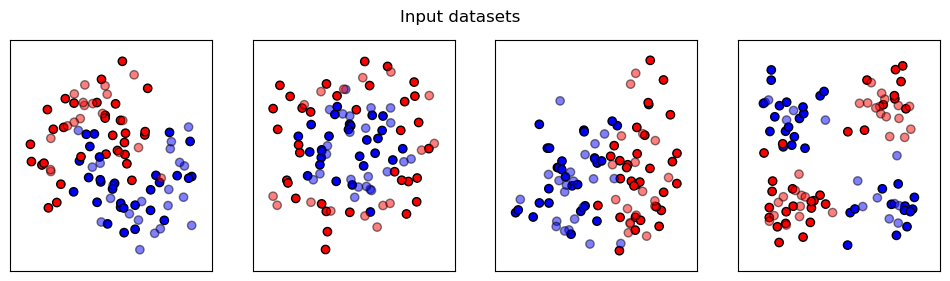

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the datasets first
figure = plt.figure(figsize=(12, 3))
figure.suptitle('Input datasets')
for i, ds in enumerate(datasets):
    ax = plt.subplot(1, len(datasets), i+1)
    # Plot the training points
    ax.scatter(ds['X_train'][:, 0], ds['X_train'][:, 1], c=ds['y_train'], cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        ds['X_test'][:, 0], ds['X_test'][:, 1], c=ds['y_test'], cmap=cm_bright, alpha=0.5, edgecolors="k"
    )
    x_min, x_max = ds['X'][:, 0].min() - 0.5, ds['X'][:, 0].max() + 0.5
    y_min, y_max = ds['X'][:, 1].min() - 0.5, ds['X'][:, 1].max() + 0.5

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Training SVM

First of all, we want to train a SVM classifier with [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).

We'll train an SVM for each of the following kernels: linear, 3rd degree polynomial, and rbf (gaussian kernel).

In [7]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'sigmoid', 'rbf']
models = [[SVC(kernel=k).fit(ds['X_train'], ds['y_train']) for k in kernels] for ds in datasets]

## Test SVM

Next, we want to test the performance of pretrained SVM classifier.

In [8]:
from IPython.display import Markdown as md

table = []
for i, ds in enumerate(datasets):
    row = []
    for j, ker in enumerate(kernels):
        accuracy = models[i][j].score(ds['X_test'], ds['y_test'])
        row.append(accuracy)
    table.append(row)

header = '|  |' + ' | '.join(k for k in kernels) + ' |\n'
header += '|' + '--|'*(len(kernels)+1) + '\n'
rows = '\n'.join(
    f'| dataset {i} | ' + ' | '.join(f'{table[i][j]*100:.2f}' for j in range(len(kernels))) + ' |'
    for i in range(len(datasets))
)
md('## Sklearn SVM performance\n' + header + rows)

## Sklearn SVM performance
|  |linear | poly | sigmoid | rbf |
|--|--|--|--|--|
| dataset 0 | 87.50 | 87.50 | 85.00 | 95.00 |
| dataset 1 | 40.00 | 40.00 | 32.50 | 87.50 |
| dataset 2 | 95.00 | 82.50 | 87.50 | 95.00 |
| dataset 3 | 62.50 | 45.00 | 52.50 | 100.00 |

## Visualizing SVM decision boundaries and support vectors

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

def vis_decision_boundaries(datasets, kernels, models, show_support=False):
    figure = plt.figure(figsize=(len(datasets)*5, (len(kernels)+1)*3))
    for i, ds in enumerate(datasets):
        # Plot the datasets first
        ax = plt.subplot(len(datasets), len(kernels)+1, i*(len(kernels)+1)+1)
        if i == 0:
            ax.set_title('Input data')
        # Plot the training points
        ax.scatter(ds['X_train'][:, 0], ds['X_train'][:, 1], c=ds['y_train'], cmap=cm_bright, edgecolors="k")
        # Plot the testing points
        ax.scatter(
            ds['X_test'][:, 0], ds['X_test'][:, 1], c=ds['y_test'], cmap=cm_bright, alpha=0.5, edgecolors="k"
        )
        x_min, x_max = ds['X'][:, 0].min() - 0.5, ds['X'][:, 0].max() + 0.5
        y_min, y_max = ds['X'][:, 1].min() - 0.5, ds['X'][:, 1].max() + 0.5
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

        for j, ker in enumerate(kernels):
            base_alpha = 0.2 if show_support else 1.0
            ax = plt.subplot(len(datasets), len(kernels)+1, i*(len(kernels)+1)+j+2)
            score = models[i][j].score(ds['X_test'], ds['y_test'])
            DecisionBoundaryDisplay.from_estimator(
                models[i][j], ds['X'], cmap=cm, alpha=0.8, ax=ax, eps=0.5
            )

            # Plot the training points
            ax.scatter(ds['X_train'][:, 0], ds['X_train'][:, 1], c=ds['y_train'], cmap=cm_bright, alpha=base_alpha, edgecolors="k")
            # Plot the testing points
            ax.scatter(
                ds['X_test'][:, 0], ds['X_test'][:, 1], c=ds['y_test'], cmap=cm_bright, alpha=0.5*base_alpha, edgecolors="k"
            )

            if show_support:
                # Support vectors
                support_idxs = models[i][j].support_
                support, support_y = ds['X_train'][support_idxs], ds['y_train'][support_idxs]
                ax.scatter(
                    support[:, 0], support[:, 1], c=support_y, cmap=cm_bright, edgecolors="k"
                )
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())

            if i == 0:
                ax.set_title(ker + ' supports' if show_support else ker)
            if not show_support:
                ax.text(
                    x_max - 0.3,
                    y_min + 0.3,
                    f'{score*100:.1f}%',
                    size=15,
                    horizontalalignment="right",
                    weight="bold",
                )

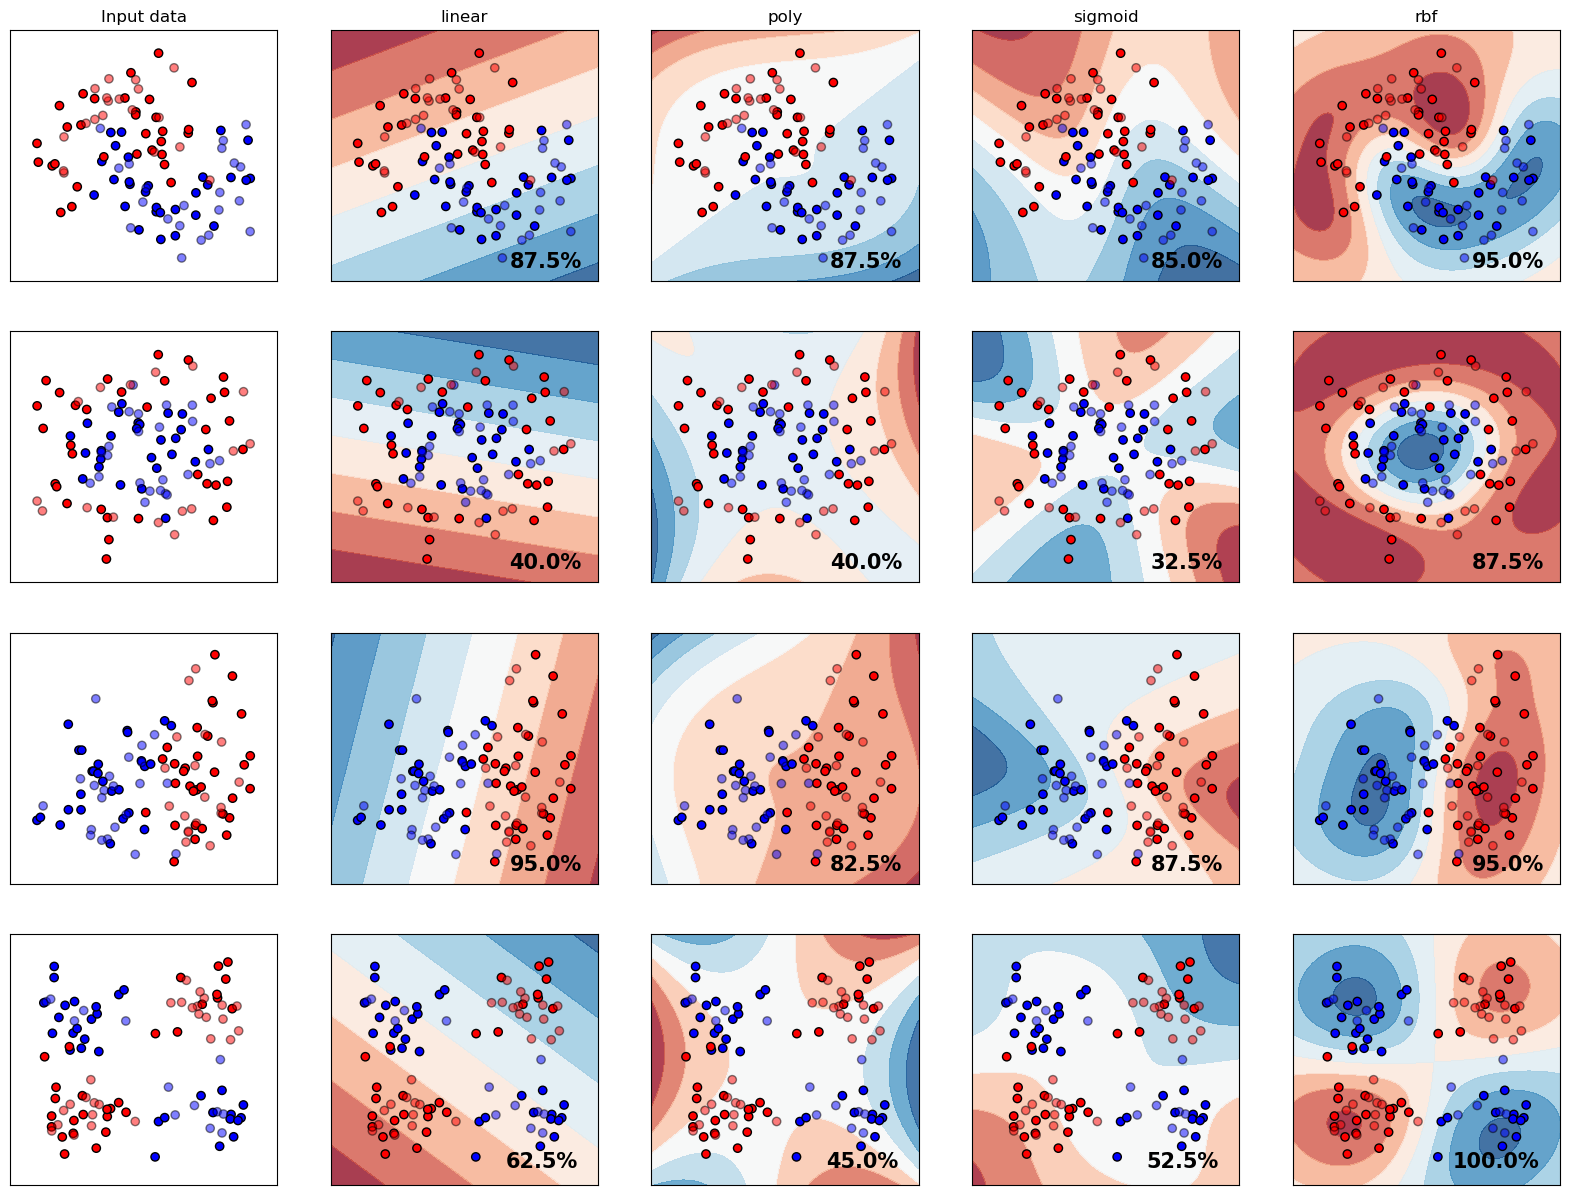

In [10]:
vis_decision_boundaries(datasets, kernels, models, show_support=False)

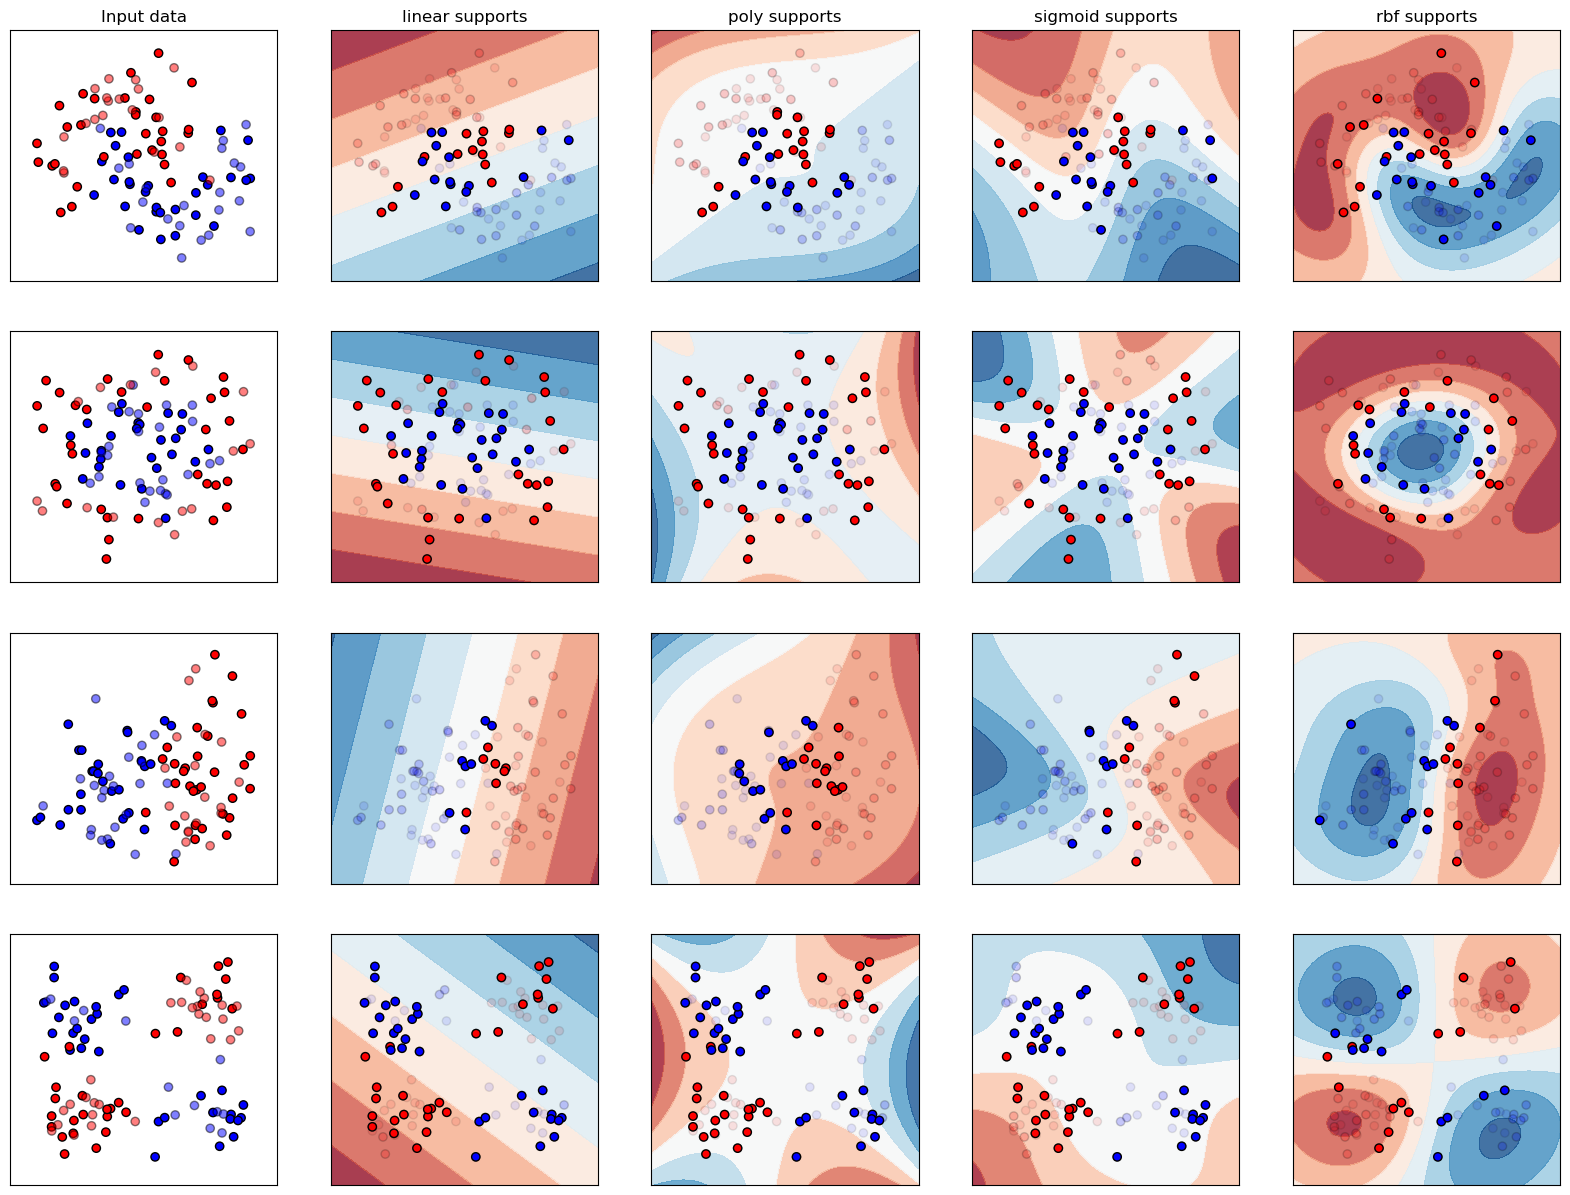

In [11]:
vis_decision_boundaries(datasets, kernels, models, show_support=True)

## CVXOPT SVM

Next, we will implement a kernelized SVM using the cvxopt library. <span class="instruction">Please complete the functions `get_qp_params`, `fit_bias`, and `decision_function` of `cvxopt_svm.py`</span>

Please make sure your code works for any passed in kernel (i.e. any value of `kernel_params`).

### Sanity Checks
Use the code below to (partially) check whether your code is correct. A complete check will be performed on the autograder.

In [17]:
from gradient_check import rel_error
from cvxopt_svm import get_qp_params, fit_bias, decision_function

rng = np.random.default_rng(545)
X = rng.normal(size=(5, 4))
y = rng.normal(size=(5,))
alpha = rng.binomial(5, 0.2, size=(5,))
C = 1.0
kernel_params = {'kernel': 'rbf', 'degree': 3, 'gamma': 0.2, 'coef0': 0.0}
P, _, _, _, _, _ = get_qp_params(X, y, C, kernel_params)
b = fit_bias(X, y, alpha, kernel_params)
h = decision_function(X[:2], X, y, 545, alpha, kernel_params)

P_sol = np.array([[ 0.45863879, -0.36760293, -0.09673795,  0.00553096, -0.01048321],
       [-0.36760293,  1.09673362,  0.06906934, -0.13144294,  0.13565593],
       [-0.09673795,  0.06906934,  0.46197662, -0.00232898,  0.01221352],
       [ 0.00553096, -0.13144294, -0.00232898,  1.84930408, -0.23840086],
       [-0.01048321,  0.13565593,  0.01221352, -0.23840086,  0.33240564]])

b_sol = -0.4461256227781483
h_sol = np.array([545.8439719 , 546.30869188])

# Compare your output with ours. The error might be less than 1e-7.
# As long as your error is small enough, your implementation should pass this test.
print('Testing cvxopt functions:')
print('difference: ', rel_error(P, P_sol))
print('difference: ', rel_error(b, b_sol))
print('difference: ', rel_error(h, h_sol))
print()
np.testing.assert_allclose(P, P_sol, atol=1e-6)
np.testing.assert_allclose(b, b_sol, atol=1e-6)
np.testing.assert_allclose(h, h_sol, atol=1e-6)

Testing cvxopt functions:
difference:  8.152084993766842e-07
difference:  0.0
difference:  3.691589915611581e-12



## Test SVM

Next, we want to test the performance of the cvxopt SVM classifier.

In [18]:
from cvxopt_svm import CVXOPTSVC

kernels = ['linear', 'poly', 'sigmoid', 'rbf']
cvxopt_models = [[CVXOPTSVC(kernel=k, gamma=0.2).fit(ds['X_train'], ds['y_train']) for k in kernels] for ds in datasets]

In [19]:
from IPython.display import Markdown as md

table = []
for i, ds in enumerate(datasets):
    row = []
    for j, ker in enumerate(kernels):
        pred = cvxopt_models[i][j].predict(ds['X_test'])

        accuracy = (pred == ds['y_test']).mean()
        row.append(accuracy)
    table.append(row)

header = '|  |' + ' | '.join(k for k in kernels) + ' |\n'
header += '|' + '--|'*(len(kernels)+1) + '\n'
rows = '\n'.join(
    f'| dataset {i} | ' + ' | '.join(f'{table[i][j]*100:.2f}' for j in range(len(kernels))) + ' |'
    for i in range(len(datasets))
)
md('## CVXOPTSVM performance\n' + header + rows)

## CVXOPTSVM performance
|  |linear | poly | sigmoid | rbf |
|--|--|--|--|--|
| dataset 0 | 90.00 | 87.50 | 87.50 | 95.00 |
| dataset 1 | 40.00 | 40.00 | 40.00 | 90.00 |
| dataset 2 | 95.00 | 95.00 | 95.00 | 95.00 |
| dataset 3 | 57.50 | 55.00 | 60.00 | 97.50 |

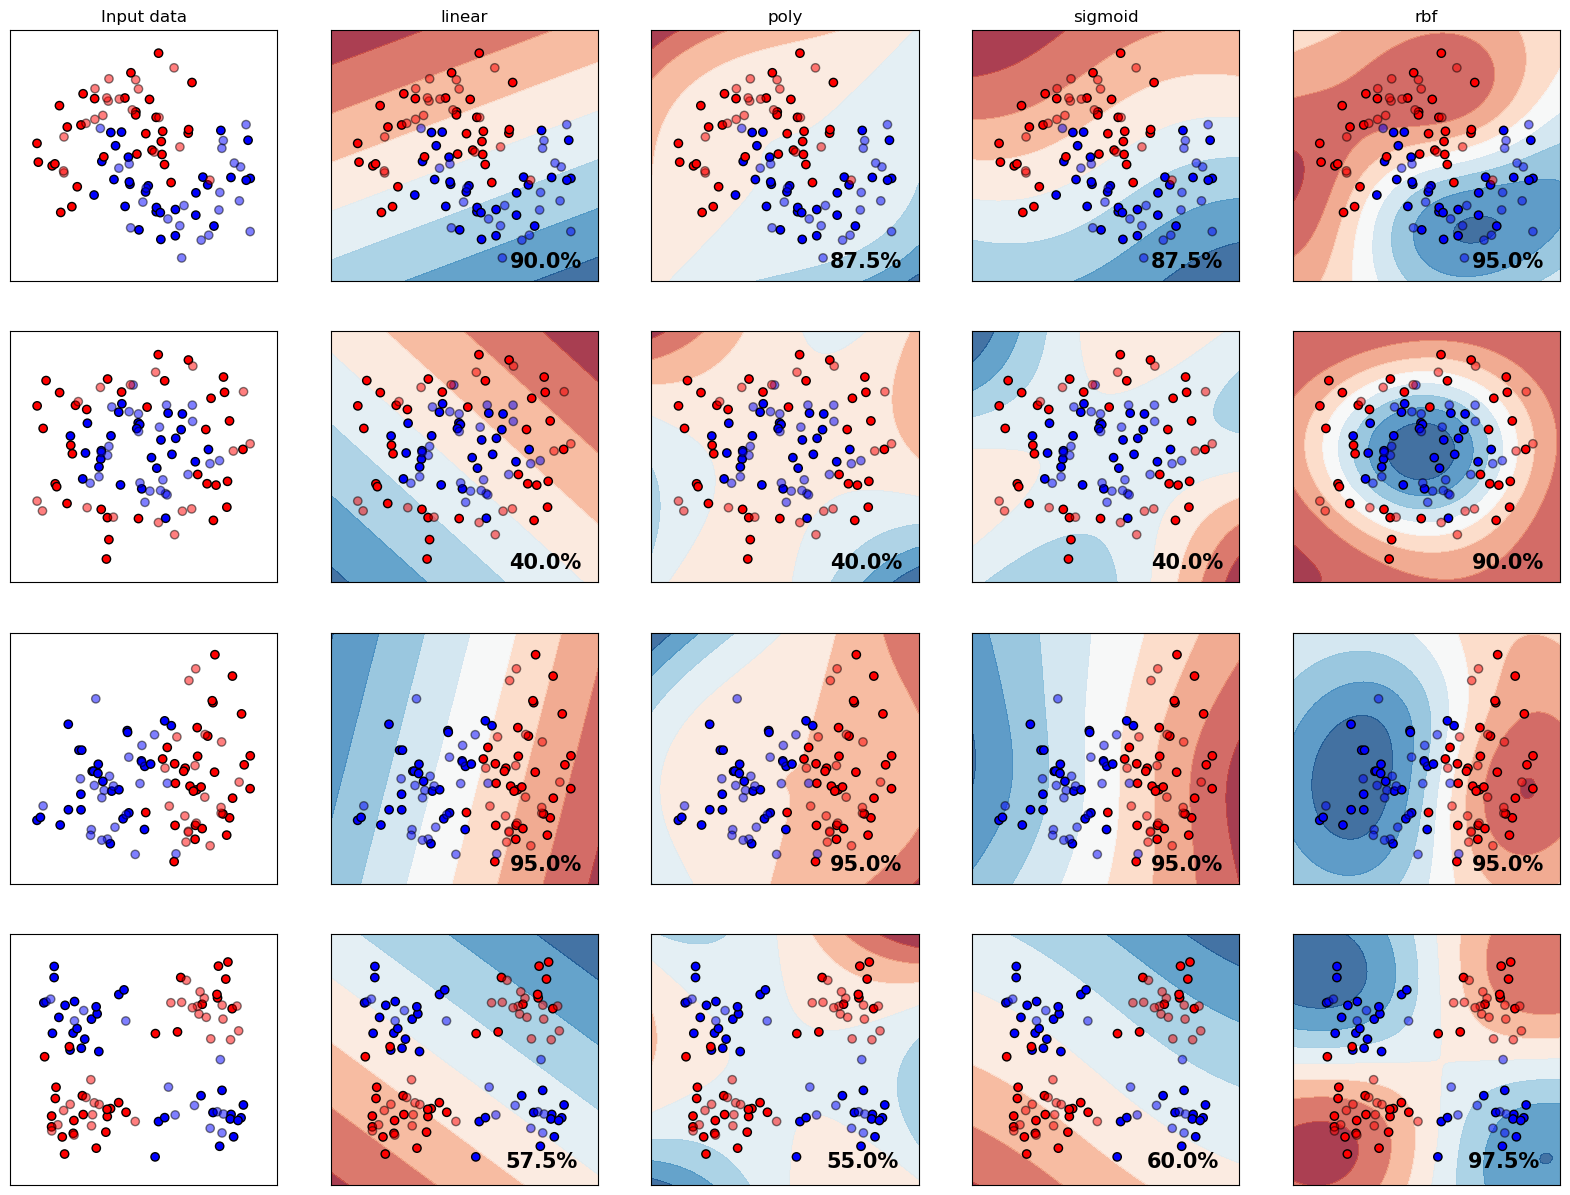

In [20]:
vis_decision_boundaries(datasets, kernels, cvxopt_models, show_support=False)

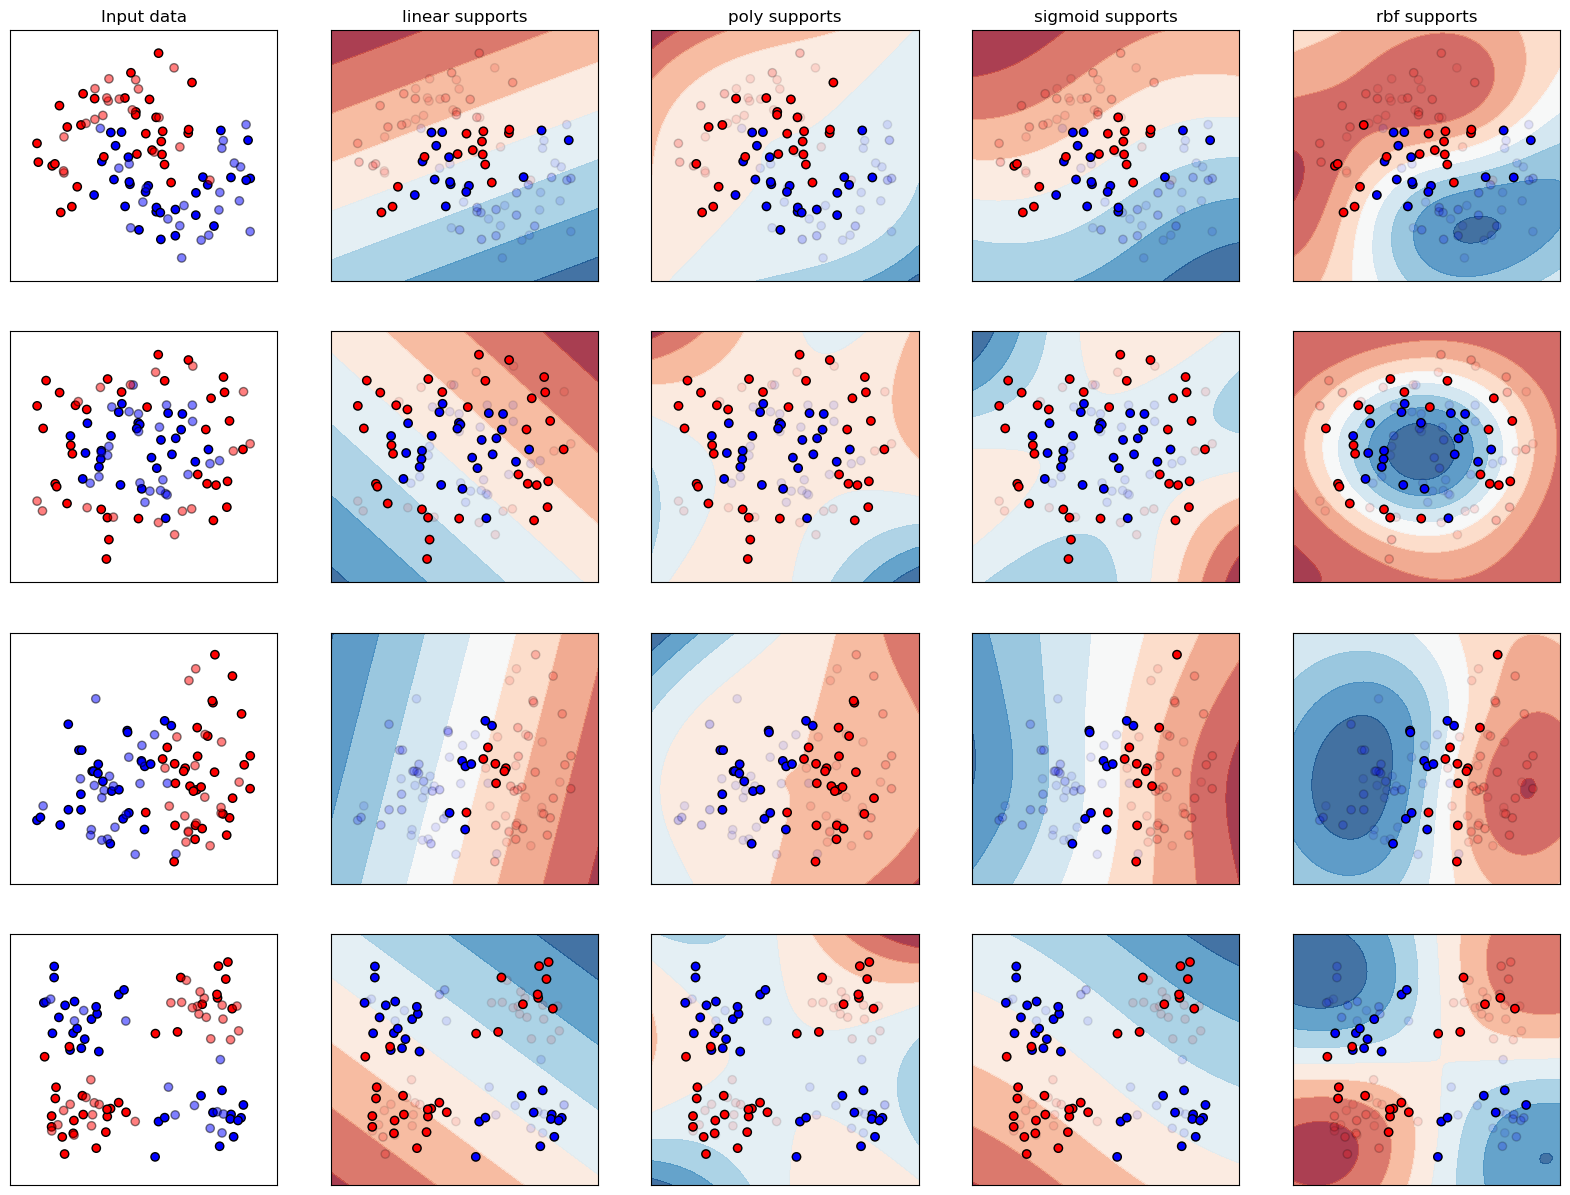

In [21]:
vis_decision_boundaries(datasets, kernels, cvxopt_models, show_support=True)